In [3]:
# Cell 1: імпорти
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats

# Налаштування візуалізації
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,5)

In [4]:
# Cell 2: шлях до файлу
DATA_PATH = "D:/4Курс/Машинне навчання/Labs/1/Student_Performance.csv"  
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
display(df.info())

Shape: (10000, 6)


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Hours Studied,10000.0,NaN,NaN,NaN,4.9929,2.589309,1.0,3.0,5.0,7.0,9.0
Previous Scores,10000.0,NaN,NaN,NaN,69.4457,17.343152,40.0,54.0,69.0,85.0,99.0
Extracurricular Activities,10000,2,No,5052,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep Hours,10000.0,NaN,NaN,NaN,6.5306,1.695863,4.0,5.0,7.0,8.0,9.0
Sample Question Papers Practiced,10000.0,NaN,NaN,NaN,4.5833,2.867348,0.0,2.0,5.0,7.0,9.0
Performance Index,10000.0,NaN,NaN,NaN,55.2248,19.212558,10.0,40.0,55.0,71.0,100.0


Missing values:
 Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


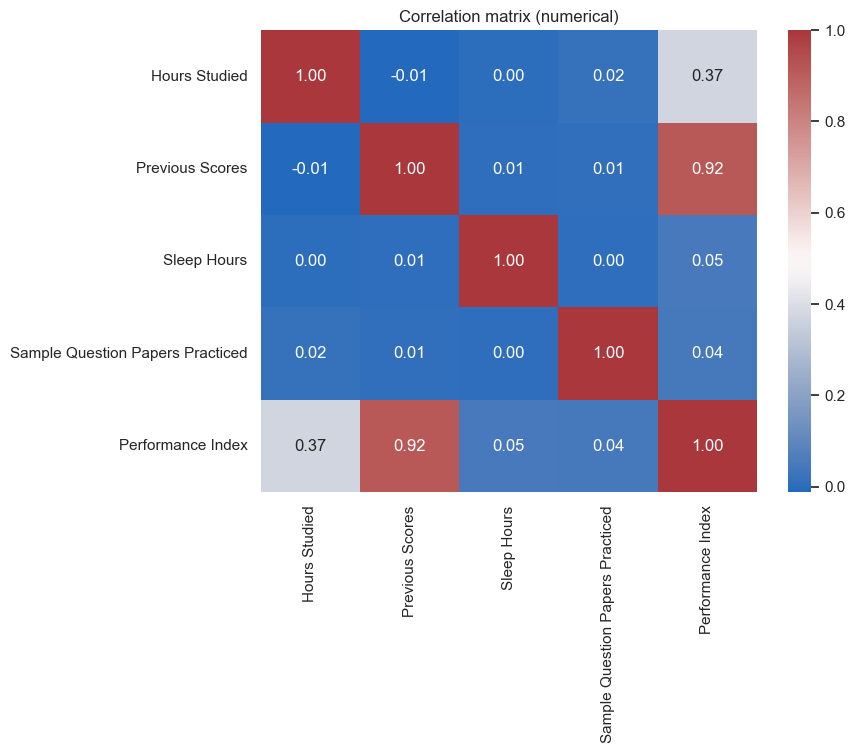

In [5]:
# Cell 3: простий EDA
display(df.describe(include='all').T)
print("Missing values:\n", df.isnull().sum())

# Кореляція чисельних колонок
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='vlag')
plt.title("Correlation matrix (numerical)")
plt.show()


In [6]:

# Cell 4: Преобробка категоріальної змінної
# Припустимо: 'Extracurricular Activities' має 'Yes'/'No'
if 'Extracurricular Activities' in df.columns:
    df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes':1, 'No':0})

# Перевірка типів
display(df.dtypes)



Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities            int64
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object

In [7]:
# Cell 5: вибір ознак і цілі
target = 'Performance Index'
features = [c for c in df.columns if c != target]
print("Features used:", features)

X = df[features].copy()
y = df[target].values

# Якщо потрібно — видалити NaN або заповнити
if X.isnull().any().any() or pd.isnull(y).any():
    print("Заповнюю пропуски середнім (можна змінити стратегію)")
    X = X.fillna(X.mean())
    y = pd.Series(y).fillna(pd.Series(y).mean()).values


Features used: ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']


In [8]:
# Cell 6: train/test split та масштабування
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Додаємо стовпець одиниць для інтерсепта
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final  = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print("X_train_final shape:", X_train_final.shape, "X_test_final shape:", X_test_final.shape)


X_train_final shape: (8000, 6) X_test_final shape: (2000, 6)


In [9]:
# Cell 7: реалізація векторизованого градієнтного спуску (MSE)
def compute_cost(X, y, b):
    n = len(y)
    preds = X.dot(b)
    errors = preds - y
    mse = (1.0 / n) * np.sum(errors ** 2)
    return mse

def gradient_descent(X, y, b_init, learning_rate=0.01, epochs=1000, verbose=False):
    n = len(y)
    b = b_init.copy()
    cost_history = np.zeros(epochs)
    for i in range(epochs):
        preds = X.dot(b)
        errors = preds - y
        grad = (2.0 / n) * X.T.dot(errors)   # градієнт MSE
        b -= learning_rate * grad
        cost_history[i] = compute_cost(X, y, b)
        if verbose and (i % (epochs//10 if epochs>=10 else 1) == 0):
            print(f"Iter {i:5d}, cost={cost_history[i]:.6f}")
    return b, cost_history

# ініціалізація
np.random.seed(42)
b0 = np.zeros(X_train_final.shape[1])

# Гіперпараметри — при потребі зміни
learning_rate = 0.01
epochs = 3000

b_final, cost_history = gradient_descent(X_train_final, y_train, b0,
                                        learning_rate=learning_rate,
                                        epochs=epochs,
                                        verbose=True)

print("Training finished. Final cost:", cost_history[-1])

Iter     0, cost=3292.539047
Iter   300, cost=4.187826
Iter   600, cost=4.169736
Iter   900, cost=4.169736
Iter  1200, cost=4.169736
Iter  1500, cost=4.169736
Iter  1800, cost=4.169736
Iter  2100, cost=4.169736
Iter  2400, cost=4.169736
Iter  2700, cost=4.169736
Training finished. Final cost: 4.169735849525006


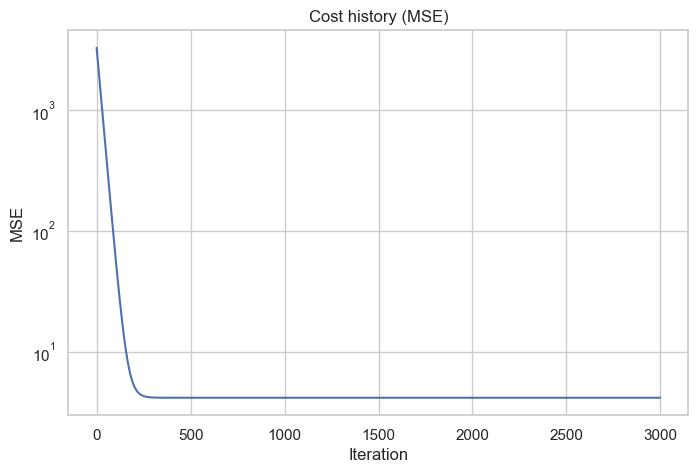

In [10]:
# Cell 8: графік збіжності
plt.plot(cost_history)
plt.title("Cost history (MSE)")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.yscale('log')
plt.show()

In [11]:

# Cell 9: прогноз та метрики на тесті
y_pred = X_test_final.dot(b_final)
mse_test = mean_squared_error(y_test, y_pred)
r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))

print(f"Test MSE (GD): {mse_test:.4f}")
print(f"Test R^2 (GD): {r2:.4f}")

# baseline: передбачати середнє y_train
baseline_pred = np.full_like(y_test, np.mean(y_train))
baseline_mse = mean_squared_error(y_test, baseline_pred)
print(f"Baseline MSE (predict mean): {baseline_mse:.4f}")

# Для перевірки: порівняй з sklearn LinearRegression (аналітичне)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Sklearn LinearRegression MSE:", mean_squared_error(y_test, y_pred_lr))


Test MSE (GD): 4.0826
Test R^2 (GD): 0.9890
Baseline MSE (predict mean): 370.7730
Sklearn LinearRegression MSE: 4.082628398521842


In [12]:

# Cell 10: коефіцієнти у зрозумілому вигляді
feature_names = ['Intercept'] + list(X.columns)
coef_df = pd.DataFrame({'feature': feature_names, 'coef': b_final})
display(coef_df)

,feature,coef
0,Intercept,55.311500
1,Hours Studied,7.401341
2,Previous Scores,17.637271
3,Extracurricular Activities,0.304291
4,Sleep Hours,0.810031
5,Sample Question Papers Practiced,0.548842


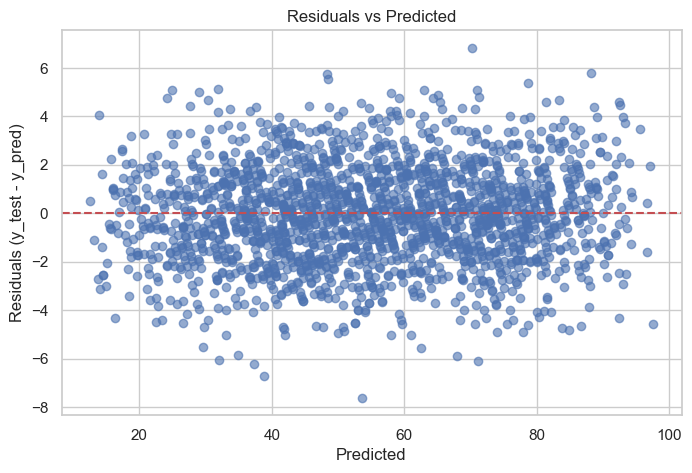

In [13]:
# Cell 11: Аналіз припущень - залишки
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residuals vs Predicted")
plt.show()

In [14]:

# Cell 12: VIF - мультиколінеарність (для масштабованих ознак, без інтерсепта)
X_scaled_df = pd.DataFrame(scaler.transform(X), columns=X.columns)  # всі фічі scaled
vif_data = pd.DataFrame()
vif_data['feature'] = X_scaled_df.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled_df.values, i)
                   for i in range(X_scaled_df.shape[1])]
display(vif_data)

,feature,VIF
0,Hours Studied,1.000477
1,Previous Scores,1.000328
2,Extracurricular Activities,1.000802
3,Sleep Hours,1.000601
4,Sample Question Papers Practiced,1.000557


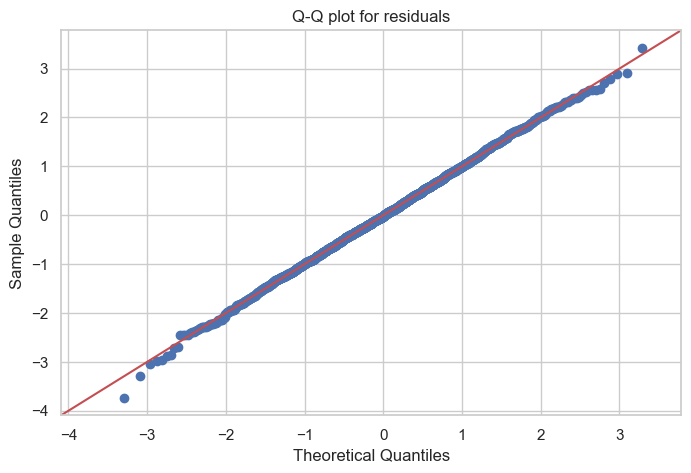

Jarque-Bera stat=0.085, p-value=0.9583
Shapiro-Wilk stat=1.000, p-value=0.9751


In [15]:
# Cell 13: Нормальність залишків - Q-Q та тести
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q plot for residuals")
plt.show()

jb_stat, jb_p = stats.jarque_bera(residuals)
print(f"Jarque-Bera stat={jb_stat:.3f}, p-value={jb_p:.4f}")

try:
    sh_stat, sh_p = stats.shapiro(residuals)
    print(f"Shapiro-Wilk stat={sh_stat:.3f}, p-value={sh_p:.4f}")
except Exception as e:
    print("Shapiro test may fail on large samples:", e)


In [16]:
# Cell 14: Гомоскедастичність - тест Бреуша-Пагана (на train моделі через statsmodels OLS)
X_sm_train = sm.add_constant(X_train_scaled)
ols_train = sm.OLS(y_train, X_sm_train).fit()
bp_test = het_breuschpagan(ols_train.resid, ols_train.model.exog)
labels = ['LM stat', 'LM p-value', 'F stat', 'F p-value']
print(dict(zip(labels, bp_test)))

{'LM stat': np.float64(6.7535402739391515), 'LM p-value': np.float64(0.2396245087908097), 'F stat': np.float64(1.3508353888969733), 'F p-value': np.float64(0.23970012650120423)}


In [17]:
# Cell 15: Durbin-Watson (автокореляція залишків) — на тестових залишках
dw = durbin_watson(residuals)
print("Durbin-Watson statistic (test residuals):", dw)
# інтерпретація: близько 2 => немає автокореляції

Durbin-Watson statistic (test residuals): 2.047191039710491


Cook's distance threshold (4/n): 0.0004


,cooks_d
7468,0.002092
686,0.001777
3719,0.001737
6976,0.001643
684,0.001581
8721,0.001415
7876,0.001407
6228,0.001338
8021,0.001331
8266,0.001295


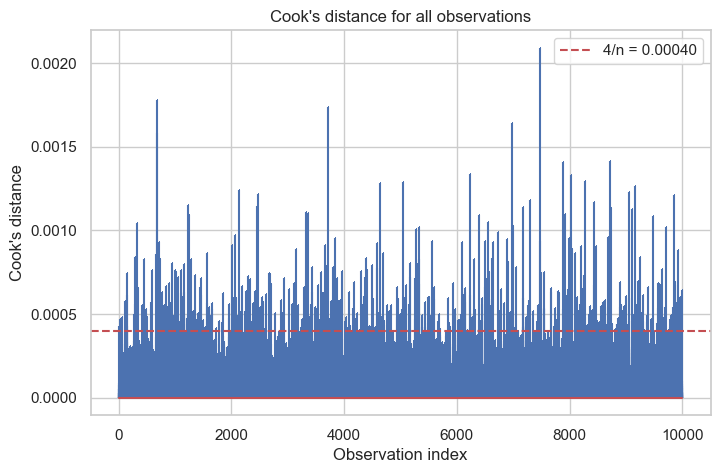

In [18]:
# Cell 16: Cook's distance — впливові спостереження
# Побудуємо OLS на всіх даних (масштабованих) для influence
X_all_sm = sm.add_constant(X_scaled_df)
ols_all = sm.OLS(y, X_all_sm).fit()
influence = ols_all.get_influence()
cooks_d, pvals = influence.cooks_distance

n = X_all_sm.shape[0]
threshold = 4.0 / n
print("Cook's distance threshold (4/n):", threshold)
cook_df = pd.DataFrame({'cooks_d': cooks_d})
display(cook_df.sort_values('cooks_d', ascending=False).head(10))

plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(threshold, color='r', linestyle='--', label=f'4/n = {threshold:.5f}')
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.title("Cook's distance for all observations")
plt.legend()
plt.show()

In [19]:
# Cell 17: Підсумок (вивід)
print("=== Summary ===")
print(f"Test MSE (Gradient Descent): {mse_test:.4f}")
print(f"Test R^2 (Gradient Descent): {r2:.4f}")
print(f"Baseline MSE (predict mean): {baseline_mse:.4f}")
print("Перевірте графіки та результати тестів вище для оцінки 6 припущень OLS.")

=== Summary ===
Test MSE (Gradient Descent): 4.0826
Test R^2 (Gradient Descent): 0.9890
Baseline MSE (predict mean): 370.7730
Перевірте графіки та результати тестів вище для оцінки 6 припущень OLS.
